<a href="https://colab.research.google.com/github/tawhidliyon/codealpha_tasks/blob/main/face_emotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip /content/fer2013.zip

Streaming output truncated to the last 5000 lines.
 extracting: fer2013/train/sad/Training_65267116.jpg  
 extracting: fer2013/train/sad/Training_65275626.jpg  
 extracting: fer2013/train/sad/Training_6529266.jpg  
 extracting: fer2013/train/sad/Training_65329617.jpg  
 extracting: fer2013/train/sad/Training_65338712.jpg  
 extracting: fer2013/train/sad/Training_65338797.jpg  
 extracting: fer2013/train/sad/Training_65387162.jpg  
 extracting: fer2013/train/sad/Training_65404494.jpg  
 extracting: fer2013/train/sad/Training_65426218.jpg  
 extracting: fer2013/train/sad/Training_65430136.jpg  
 extracting: fer2013/train/sad/Training_65437377.jpg  
 extracting: fer2013/train/sad/Training_6545735.jpg  
 extracting: fer2013/train/sad/Training_65463385.jpg  
 extracting: fer2013/train/sad/Training_65473985.jpg  
 extracting: fer2013/train/sad/Training_65502829.jpg  
 extracting: fer2013/train/sad/Training_65505359.jpg  
 extracting: fer2013/train/sad/Training_65508578.jpg  
 extracting: fer

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from IPython.display import display
import ipywidgets as widgets
import time
import warnings
warnings.filterwarnings('ignore')

In [3]:
BASE_DATASET_PATH = '/content/fer2013'
TRAIN_PATH = os.path.join(BASE_DATASET_PATH, 'train')
TEST_PATH = os.path.join(BASE_DATASET_PATH, 'test')


emotion_categories = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

In [4]:
def load_dataset(dataset_path, img_size=(48, 48)):

    X = []
    y = []

    for emotion_idx, emotion_name in enumerate(emotion_categories):
        emotion_folder = os.path.join(dataset_path, emotion_name)
        if not os.path.exists(emotion_folder):
            print(f"Warning: Folder {emotion_folder} not found. Skipping...")
            continue

        print(f"Processing {emotion_name} images from {emotion_folder}...")
        image_files = [f for f in os.listdir(emotion_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]

        for image_file in image_files:
            try:
                img_path = os.path.join(emotion_folder, image_file)


                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    print(f"Warning: Could not read {img_path}. Skipping...")
                    continue


                img = cv2.resize(img, img_size)


                X.append(img)
                y.append(emotion_idx)

            except Exception as e:
                print(f"Error processing {image_file}: {e}")


    X = np.array(X)
    y = np.array(y)

    # Reshape and normalize X
    X = X.reshape(-1, img_size[0], img_size[1], 1)
    X = X / 255.0

    # Convert y to one-hot encoding
    y = tf.keras.utils.to_categorical(y, len(emotion_categories))

    return X, y

In [5]:
print("Loading training data...")
X_train, y_train = load_dataset(TRAIN_PATH)

print("Loading testing data...")
X_test, y_test = load_dataset(TEST_PATH)

# Create a validation set from the training data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print("Data loading complete!")
print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Loading training data...
Processing angry images from /content/fer2013/train/angry...
Processing disgust images from /content/fer2013/train/disgust...
Processing fear images from /content/fer2013/train/fear...
Processing happy images from /content/fer2013/train/happy...
Processing sad images from /content/fer2013/train/sad...
Processing surprise images from /content/fer2013/train/surprise...
Processing neutral images from /content/fer2013/train/neutral...
Loading testing data...
Processing angry images from /content/fer2013/test/angry...
Processing disgust images from /content/fer2013/test/disgust...
Processing fear images from /content/fer2013/test/fear...
Processing happy images from /content/fer2013/test/happy...
Processing sad images from /content/fer2013/test/sad...
Processing surprise images from /content/fer2013/test/surprise...
Processing neutral images from /content/fer2013/test/neutral...
Data loading complete!
Training samples: 25838
Validation samples: 2871
Testing samples:

In [6]:
def build_model(input_shape=(48, 48, 1), num_classes=7):
    model = Sequential()

    # First convolutional block
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))

    # Second convolutional block
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))

    # Third convolutional block
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))

    # Flatten and dense layers
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

model = build_model(num_classes=len(emotion_categories))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 5,872,583 (22.40 MB)

 Trainable params: 5,869,767 (22.39 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [7]:
def setup_training():
    # Data augmentation to improve model generalization
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True
    )

    # Callbacks to improve training
    checkpoint = ModelCheckpoint(
        "emotion_model_best.h5",
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=0.00001,
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        min_delta=0.001,
        patience=10,
        verbose=1,
        restore_best_weights=True
    )

    callbacks = [checkpoint, reduce_lr, early_stopping]
    return datagen, callbacks

datagen, callbacks = setup_training()

In [8]:
def train_model(epochs=50, batch_size=64):
    history = model.fit(
        datagen.flow(X_train, y_train, batch_size=batch_size),
        steps_per_epoch=len(X_train) // batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val),
        callbacks=callbacks
    )

    # Save the model
    model.save('emotion_model_final.h5')
    return history

# Train the model - uncomment to train
history = train_model(epochs=50)

Epoch 1/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.1982 - loss: 2.7728
Epoch 1: val_accuracy improved from -inf to 0.17346, saving model to emotion_model_best.h5


403/403 ━━━━━━━━━━━━━━━━━━━━ 46s 76ms/step - accuracy: 0.1982 - loss: 2.7723 - val_accuracy: 0.1735 - val_loss: 3.1866 - learning_rate: 1.0000e-04
Epoch 2/50
  1/403 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.2969 - loss: 2.1715
Epoch 2: val_accuracy did not improve from 0.17346
403/403 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2969 - loss: 2.1715 - val_accuracy: 0.1721 - val_loss: 3.2054 - learning_rate: 1.0000e-04
Epoch 3/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2527 - loss: 2.2196
Epoch 3: val_accuracy improved from 0.17346 to 0.37443, saving model to emotion_model_best.h5


403/403 ━━━━━━━━━━━━━━━━━━━━ 57s 43ms/step - accuracy: 0.2527 - loss: 2.2194 - val_accuracy: 0.3744 - val_loss: 1.7258 - learning_rate: 1.0000e-04
Epoch 4/50
  1/403 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.2656 - loss: 2.0627
Epoch 4: val_accuracy did not improve from 0.37443
403/403 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2656 - loss: 2.0627 - val_accuracy: 0.3741 - val_loss: 1.7280 - learning_rate: 1.0000e-04
Epoch 5/50
402/403 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.2956 - loss: 2.0448
Epoch 5: val_accuracy improved from 0.37443 to 0.40160, saving model to emotion_model_best.h5


403/403 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.2956 - loss: 2.0446 - val_accuracy: 0.4016 - val_loss: 1.5770 - learning_rate: 1.0000e-04
Epoch 6/50
  1/403 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.2656 - loss: 1.9674
Epoch 6: val_accuracy improved from 0.40160 to 0.40578, saving model to emotion_model_best.h5


403/403 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2656 - loss: 1.9674 - val_accuracy: 0.4058 - val_loss: 1.5766 - learning_rate: 1.0000e-04
Epoch 7/50
402/403 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3219 - loss: 1.9064
Epoch 7: val_accuracy improved from 0.40578 to 0.44793, saving model to emotion_model_best.h5


403/403 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - accuracy: 0.3219 - loss: 1.9062 - val_accuracy: 0.4479 - val_loss: 1.4663 - learning_rate: 1.0000e-04
Epoch 8/50
  1/403 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.4531 - loss: 1.6616
Epoch 8: val_accuracy improved from 0.44793 to 0.45211, saving model to emotion_model_best.h5


403/403 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4531 - loss: 1.6616 - val_accuracy: 0.4521 - val_loss: 1.4605 - learning_rate: 1.0000e-04
Epoch 9/50
402/403 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3580 - loss: 1.7943
Epoch 9: val_accuracy improved from 0.45211 to 0.46534, saving model to emotion_model_best.h5


403/403 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.3581 - loss: 1.7942 - val_accuracy: 0.4653 - val_loss: 1.4443 - learning_rate: 1.0000e-04
Epoch 10/50
  1/403 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.3594 - loss: 1.8208
Epoch 10: val_accuracy did not improve from 0.46534
403/403 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3594 - loss: 1.8208 - val_accuracy: 0.4629 - val_loss: 1.4529 - learning_rate: 1.0000e-04
Epoch 11/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3875 - loss: 1.6947
Epoch 11: val_accuracy improved from 0.46534 to 0.47753, saving model to emotion_model_best.h5


403/403 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.3875 - loss: 1.6947 - val_accuracy: 0.4775 - val_loss: 1.4241 - learning_rate: 1.0000e-04
Epoch 12/50
  1/403 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.3125 - loss: 1.9302
Epoch 12: val_accuracy did not improve from 0.47753
403/403 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3125 - loss: 1.9302 - val_accuracy: 0.4723 - val_loss: 1.4376 - learning_rate: 1.0000e-04
Epoch 13/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4067 - loss: 1.6152
Epoch 13: val_accuracy improved from 0.47753 to 0.51445, saving model to emotion_model_best.h5


403/403 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.4067 - loss: 1.6151 - val_accuracy: 0.5145 - val_loss: 1.2982 - learning_rate: 1.0000e-04
Epoch 14/50
  1/403 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.4375 - loss: 1.5334
Epoch 14: val_accuracy improved from 0.51445 to 0.51654, saving model to emotion_model_best.h5


403/403 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4375 - loss: 1.5334 - val_accuracy: 0.5165 - val_loss: 1.2974 - learning_rate: 1.0000e-04
Epoch 15/50
402/403 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4342 - loss: 1.5409
Epoch 15: val_accuracy improved from 0.51654 to 0.53918, saving model to emotion_model_best.h5


403/403 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - accuracy: 0.4342 - loss: 1.5408 - val_accuracy: 0.5392 - val_loss: 1.2325 - learning_rate: 1.0000e-04
Epoch 16/50
  1/403 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.4688 - loss: 1.4381
Epoch 16: val_accuracy improved from 0.53918 to 0.54093, saving model to emotion_model_best.h5


403/403 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4688 - loss: 1.4381 - val_accuracy: 0.5409 - val_loss: 1.2310 - learning_rate: 1.0000e-04
Epoch 17/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4591 - loss: 1.4685
Epoch 17: val_accuracy improved from 0.54093 to 0.54267, saving model to emotion_model_best.h5


403/403 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.4591 - loss: 1.4685 - val_accuracy: 0.5427 - val_loss: 1.2097 - learning_rate: 1.0000e-04
Epoch 18/50
  1/403 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.4219 - loss: 1.5400
Epoch 18: val_accuracy improved from 0.54267 to 0.54511, saving model to emotion_model_best.h5


403/403 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4219 - loss: 1.5400 - val_accuracy: 0.5451 - val_loss: 1.2092 - learning_rate: 1.0000e-04
Epoch 19/50
402/403 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4664 - loss: 1.4224
Epoch 19: val_accuracy improved from 0.54511 to 0.55312, saving model to emotion_model_best.h5


403/403 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.4664 - loss: 1.4223 - val_accuracy: 0.5531 - val_loss: 1.2025 - learning_rate: 1.0000e-04
Epoch 20/50
  1/403 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.5312 - loss: 1.3806
Epoch 20: val_accuracy did not improve from 0.55312
403/403 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5312 - loss: 1.3806 - val_accuracy: 0.5458 - val_loss: 1.2044 - learning_rate: 1.0000e-04
Epoch 21/50
402/403 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4906 - loss: 1.3648
Epoch 21: val_accuracy improved from 0.55312 to 0.56043, saving model to emotion_model_best.h5


403/403 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.4906 - loss: 1.3648 - val_accuracy: 0.5604 - val_loss: 1.2036 - learning_rate: 1.0000e-04
Epoch 22/50
  1/403 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.4688 - loss: 1.3006
Epoch 22: val_accuracy improved from 0.56043 to 0.56078, saving model to emotion_model_best.h5


403/403 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4688 - loss: 1.3006 - val_accuracy: 0.5608 - val_loss: 1.2083 - learning_rate: 1.0000e-04
Epoch 23/50
402/403 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5011 - loss: 1.3205
Epoch 23: val_accuracy improved from 0.56078 to 0.57088, saving model to emotion_model_best.h5


403/403 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - accuracy: 0.5011 - loss: 1.3205 - val_accuracy: 0.5709 - val_loss: 1.1478 - learning_rate: 1.0000e-04
Epoch 24/50
  1/403 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.4531 - loss: 1.3165
Epoch 24: val_accuracy improved from 0.57088 to 0.57193, saving model to emotion_model_best.h5


403/403 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4531 - loss: 1.3165 - val_accuracy: 0.5719 - val_loss: 1.1450 - learning_rate: 1.0000e-04
Epoch 25/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5146 - loss: 1.2920
Epoch 25: val_accuracy did not improve from 0.57193
403/403 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - accuracy: 0.5146 - loss: 1.2920 - val_accuracy: 0.5681 - val_loss: 1.1718 - learning_rate: 1.0000e-04
Epoch 26/50
  1/403 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.5625 - loss: 1.0971
Epoch 26: val_accuracy did not improve from 0.57193
403/403 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5625 - loss: 1.0971 - val_accuracy: 0.5660 - val_loss: 1.1683 - learning_rate: 1.0000e-04
Epoch 27/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5215 - loss: 1.2716
Epoch 27: val_accuracy improved from 0.57193 to 0.58412, saving model to emotion_model_best.h5


403/403 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.5215 - loss: 1.2715 - val_accuracy: 0.5841 - val_loss: 1.1031 - learning_rate: 1.0000e-04
Epoch 28/50
  1/403 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.6406 - loss: 1.0560
Epoch 28: val_accuracy did not improve from 0.58412
403/403 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6406 - loss: 1.0560 - val_accuracy: 0.5841 - val_loss: 1.1036 - learning_rate: 1.0000e-04
Epoch 29/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5331 - loss: 1.2332
Epoch 29: val_accuracy improved from 0.58412 to 0.59631, saving model to emotion_model_best.h5


403/403 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - accuracy: 0.5331 - loss: 1.2332 - val_accuracy: 0.5963 - val_loss: 1.1050 - learning_rate: 1.0000e-04
Epoch 30/50
  1/403 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.6562 - loss: 1.0285
Epoch 30: val_accuracy did not improve from 0.59631
403/403 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6562 - loss: 1.0285 - val_accuracy: 0.5953 - val_loss: 1.1089 - learning_rate: 1.0000e-04
Epoch 31/50
402/403 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5451 - loss: 1.2109
Epoch 31: val_accuracy did not improve from 0.59631
403/403 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - accuracy: 0.5451 - loss: 1.2108 - val_accuracy: 0.5946 - val_loss: 1.0844 - learning_rate: 1.0000e-04
Epoch 32/50
  1/403 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.5000 - loss: 1.1437
Epoch 32: val_accuracy did not improve from 0.59631
403/403 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5000 - loss: 1.1437 - val_accuracy: 0.5942 - val_loss: 1.0837 - learning_rate: 1.000

403/403 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.5697 - loss: 1.1429 - val_accuracy: 0.5967 - val_loss: 1.0798 - learning_rate: 1.0000e-04
Epoch 38/50
  1/403 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.4375 - loss: 1.2927
Epoch 38: val_accuracy did not improve from 0.59666
403/403 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4375 - loss: 1.2927 - val_accuracy: 0.5932 - val_loss: 1.0881 - learning_rate: 1.0000e-04
Epoch 39/50
402/403 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5713 - loss: 1.1318
Epoch 39: val_accuracy improved from 0.59666 to 0.61546, saving model to emotion_model_best.h5


403/403 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.5713 - loss: 1.1319 - val_accuracy: 0.6155 - val_loss: 1.0251 - learning_rate: 1.0000e-04
Epoch 40/50
  1/403 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.5625 - loss: 1.0897
Epoch 40: val_accuracy improved from 0.61546 to 0.61686, saving model to emotion_model_best.h5


403/403 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5625 - loss: 1.0897 - val_accuracy: 0.6169 - val_loss: 1.0250 - learning_rate: 1.0000e-04
Epoch 41/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5797 - loss: 1.1252
Epoch 41: val_accuracy did not improve from 0.61686
403/403 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - accuracy: 0.5797 - loss: 1.1252 - val_accuracy: 0.6033 - val_loss: 1.0573 - learning_rate: 1.0000e-04
Epoch 42/50
  1/403 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.4844 - loss: 1.1654
Epoch 42: val_accuracy did not improve from 0.61686
403/403 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4844 - loss: 1.1654 - val_accuracy: 0.6019 - val_loss: 1.0630 - learning_rate: 1.0000e-04
Epoch 43/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5853 - loss: 1.0922
Epoch 43: val_accuracy did not improve from 0.61686
403/403 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - accuracy: 0.5853 - loss: 1.0922 - val_accuracy: 0.6047 - val_loss: 1.0490 - learning_rate: 1.0000

403/403 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - accuracy: 0.5963 - loss: 1.0743 - val_accuracy: 0.6217 - val_loss: 1.0194 - learning_rate: 1.0000e-04
Epoch 46/50
  1/403 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.5625 - loss: 1.1941
Epoch 46: val_accuracy did not improve from 0.62173
403/403 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5625 - loss: 1.1941 - val_accuracy: 0.6186 - val_loss: 1.0215 - learning_rate: 1.0000e-04
Epoch 47/50
402/403 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6005 - loss: 1.0655
Epoch 47: val_accuracy improved from 0.62173 to 0.63009, saving model to emotion_model_best.h5


403/403 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.6005 - loss: 1.0655 - val_accuracy: 0.6301 - val_loss: 1.0033 - learning_rate: 1.0000e-04
Epoch 48/50
  1/403 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.5938 - loss: 1.1254
Epoch 48: val_accuracy improved from 0.63009 to 0.63114, saving model to emotion_model_best.h5


403/403 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5938 - loss: 1.1254 - val_accuracy: 0.6311 - val_loss: 1.0020 - learning_rate: 1.0000e-04
Epoch 49/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6054 - loss: 1.0520
Epoch 49: val_accuracy did not improve from 0.63114
403/403 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.6054 - loss: 1.0520 - val_accuracy: 0.6228 - val_loss: 1.0042 - learning_rate: 1.0000e-04
Epoch 50/50
  1/403 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.6719 - loss: 0.8999
Epoch 50: val_accuracy did not improve from 0.63114
403/403 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6719 - loss: 0.8999 - val_accuracy: 0.6224 - val_loss: 1.0020 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 48.


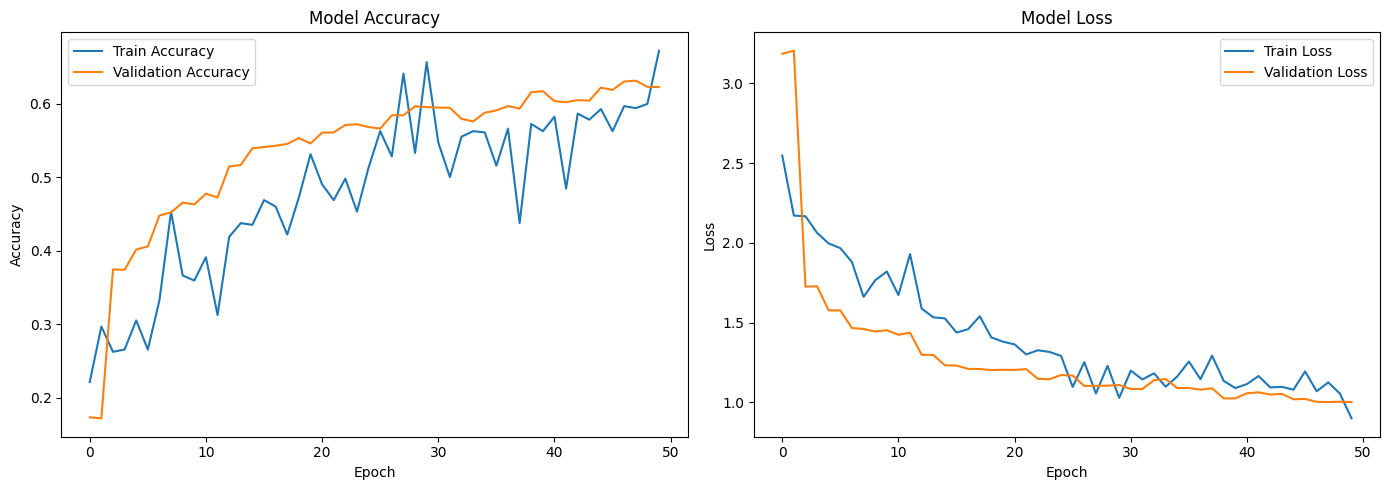

In [9]:
def plot_training_history(history):
    plt.figure(figsize=(14, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot training history if model was trained
if 'history' in locals():
    plot_training_history(history)

In [10]:
def load_trained_model():
    try:
        if os.path.exists('emotion_model_best.h5'):
            print("Loading the best saved model...")
            loaded_model = load_model('emotion_model_best.h5')
        elif os.path.exists('emotion_model_final.h5'):
            print("Loading the final saved model...")
            loaded_model = load_model('emotion_model_final.h5')
        else:
            print("No saved model found. Using the newly created model.")
            loaded_model = model
        return loaded_model
    except Exception as e:
        print(f"Error loading model: {e}")
        print("Using the newly created model.")
        return model

emotion_model = load_trained_model()

Loading the best saved model...


225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.5475 - loss: 1.1970
Test Loss: 1.0333
Test Accuracy: 0.6179
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


<Figure size 1000x800 with 0 Axes>

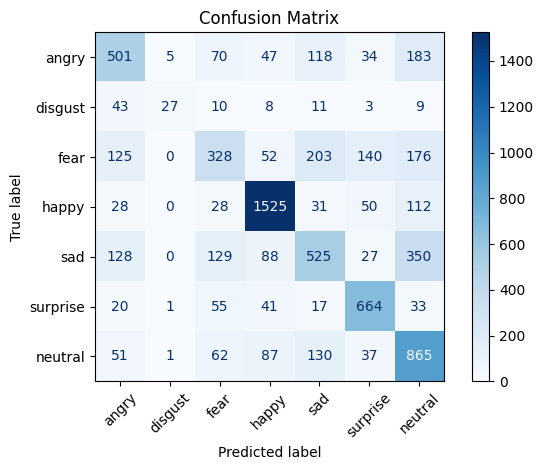

In [11]:
def evaluate_model():
    loss, accuracy = emotion_model.evaluate(X_test, y_test)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")

    # Create a confusion matrix
    y_pred = emotion_model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Plot confusion matrix
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=emotion_categories)

    plt.figure(figsize=(10, 8))
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

evaluate_model()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


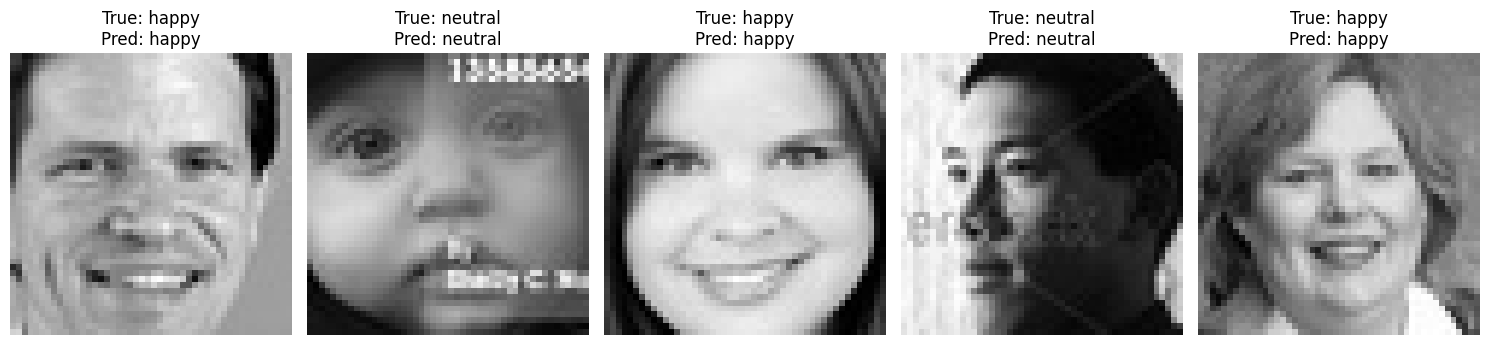

In [12]:
def visualize_predictions(num_samples=5):
    plt.figure(figsize=(15, 10))

    indices = np.random.choice(range(len(X_test)), num_samples, replace=False)

    for i, idx in enumerate(indices):
        img = X_test[idx].reshape(48, 48)
        true_emotion = np.argmax(y_test[idx])

        # Make prediction
        pred = emotion_model.predict(np.expand_dims(X_test[idx], axis=0))
        pred_emotion = np.argmax(pred)

        # Plot
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"True: {emotion_categories[true_emotion]}\nPred: {emotion_categories[pred_emotion]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize some predictions
visualize_predictions(5)
